# 0.1.3.2: TRY Gapfilled Hydraulic Trait Data Exploration

## Imports and configuration

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from src.conf.conf import get_config
from src.conf.environment import log
from src.utils.df_utils import optimize_columns

%load_ext autoreload
%autoreload 2

# Display all columns when printing a pandas DataFrame
pd.set_option("display.max_columns", None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explore and extract zipped data

Let's look at the available sheets and the attached metadata in the sheet called `MetaData`.

In [3]:
excel_fp = Path("data/raw/hydraulic_traits_knighton/GlobalTrees_Traits_Median.xlsx")
ss = pd.ExcelFile(excel_fp)
print(ss.sheet_names)
ss.parse("MetaData")

['MetaData', 'GlobalTraits_Median']


,Sheet Descriptions,Unnamed: 1
0,GlobalTraits_Median,Median imputed trait values
1,NaN,NaN
2,Traits,NaN
3,gsmax,maximum stomatal conductance (mmol1s-1m-2)
4,P12,xylem pressure at 12% conductance loss (MPa)
5,P50,xylem pressure at 50% conductance loss (MPa)
6,P88,xylem pressure at 88% conductance loss (MPa)
7,rdmax,maximum rooting depth (m)
8,WUE,water use efficiency (mmol CO21molH2O-1)
9,height,maximum plant height (m)


Let's take a look at the table structure.

In [4]:
med_traits = pd.read_excel(excel_fp, sheet_name="GlobalTraits_Median")
med_traits.head()

,spec.name,Family,Genus,Species,gsmax,P12,P50,P88,rdmax,WUE,height,SLA,LeafN
0,Abarema abbottii,Fabaceae,Abarema,abbottii,304.205390,-3.284712,-3.302094,-6.626727,6.153532,10.226736,22.648715,14.113052,28.388206
1,Abarema cochliocarpos,Fabaceae,Abarema,cochliocarpos,324.455645,-3.367262,-3.387309,-6.718929,5.091011,10.419099,23.536324,14.852607,28.971524
2,Abarema ganymedea,Fabaceae,Abarema,ganymedea,313.009331,-3.462626,-3.290247,-6.716266,4.834903,13.787605,23.229152,14.421790,29.884907
3,Abarema idiopoda,Fabaceae,Abarema,idiopoda,315.007040,-3.415831,-3.387674,-6.657138,6.131383,11.120290,20.830591,13.130596,29.114342
4,Abarema levelii,Fabaceae,Abarema,levelii,313.113065,-3.505724,-3.270625,-6.699530,4.805737,10.917451,20.729935,14.962319,29.537698


In [5]:
med_traits.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55779 entries, 0 to 55778
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   spec.name  55779 non-null  object 
 1   Family     55779 non-null  object 
 2   Genus      55779 non-null  object 
 3   Species    55779 non-null  object 
 4   gsmax      55779 non-null  float64
 5   P12        55779 non-null  float64
 6   P50        55779 non-null  float64
 7   P88        55779 non-null  float64
 8   rdmax      55779 non-null  float64
 9   WUE        55779 non-null  float64
 10  height     55778 non-null  float64
 11  SLA        55779 non-null  float64
 12  LeafN      55778 non-null  float64
dtypes: float64(9), object(4)
memory usage: 18.5 MB


## Optimize data types

The data isn't huge, but optimization never hurts. We can drop the columns for the traits we already have (`height`, `SLA`, and `LeafN`), convert strings to pyarrow, 64-bit floats to 32-bit, and then resave the file using parquet.

In [6]:
med_traits = (
    med_traits.drop(columns=["Family", "Genus", "Species", "height", "SLA", "LeafN"])
    .rename(columns={"spec.name": "speciesname"})
    .astype(
        {
            "speciesname": "string[pyarrow]",
            "gsmax": "float32",
            "P12": "float32",
            "P50": "float32",
            "P88": "float32",
            "rdmax": "float32",
            "WUE": "float32",
        }
    )
)

med_traits.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55779 entries, 0 to 55778
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   speciesname  55779 non-null  string 
 1   gsmax        55779 non-null  float32
 2   P12          55779 non-null  float32
 3   P50          55779 non-null  float32
 4   P88          55779 non-null  float32
 5   rdmax        55779 non-null  float32
 6   WUE          55779 non-null  float32
dtypes: float32(6), string(1)
memory usage: 2.7 MB


Lastly, let's see if the species names are already truncated down to the first two words.

In [7]:
med_traits.speciesname.str.split().str.len().value_counts()


speciesname
2    55583
4      192
3        4
Name: count, dtype: int64

Let's inspect some of these $>$ 2-word species names.

In [8]:
word_counts_to_sample = [3, 4]
for word_count in word_counts_to_sample:
    subset = med_traits[med_traits.speciesname.str.split().str.len() == word_count]
    if len(subset) > 0:
        sample_size = min(5, len(subset))
        sample = subset.sample(n=sample_size, random_state=42)
        print(f"\nWord count {word_count} (n={len(subset)}):")
        print(sample[["speciesname"]].to_string(index=False))



Word count 3 (n=4):
         speciesname
Quercus Ã— auzandrii
  Quercus Ã— kerneri
  Betula Ã— purpusii
Quercus Ã— hispanica

Word count 4 (n=192):
                             speciesname
     Calophyllum calaba  var. bracteatum
Pavetta gardeniifolia  var. subtomentosa
     Dysoxylum mollissimum  subsp. molle
  Phyllanthus niruri  subsp. lathyroides
  Ligustrum robustum  subsp. perrottetii


Let's look into how many varieties/subspecies/cultivars we actually have after trimming the specifiying names off of the Genus+species name.

In [9]:
med_traits["speciesname"].str.extract(
    "([A-Za-z]+ [A-Za-z]+)", expand=False
).str.lower().value_counts()

speciesname
acer saccharum             6
acer pectinatum            5
acer cappadocicum          3
acer sterculiaceum         3
antidesma montanum         3
                          ..
zygogynum semecarpoides    1
zygogynum staufferianum    1
zygogynum sylvestre        1
zygogynum tieghemii        1
zygogynum vinkii           1
Name: count, Length: 55615, dtype: int64[pyarrow]

In our estimation, as we don't have the knowledge of how many individual observations of the varieties there were prior to median aggregation—and given that it is likely that there were more observations of non-varieties than varieties—it is likely not so prudent to further aggregate the median aggregate trait values as it would risk over-weighting the influence of varieties.

In this case, we will elect to simply drop variety observations given that they only make up a small percentage of the total species observations.

In [10]:
med_traits = med_traits[
    med_traits.speciesname.str.split().str.len() == 2
]

med_traits["speciesname"] = med_traits["speciesname"].str.lower()

## Check for outliers and filter if necessary

The gap-filling process isn't perfect, and may have resulted in outliers due to either issues in parsing units or model anomalies. For example, the "height" trait in this dataset lists a maximum height of over 500,000 kilometers! Let's check the distributions of the traits to see if we have many outliers.

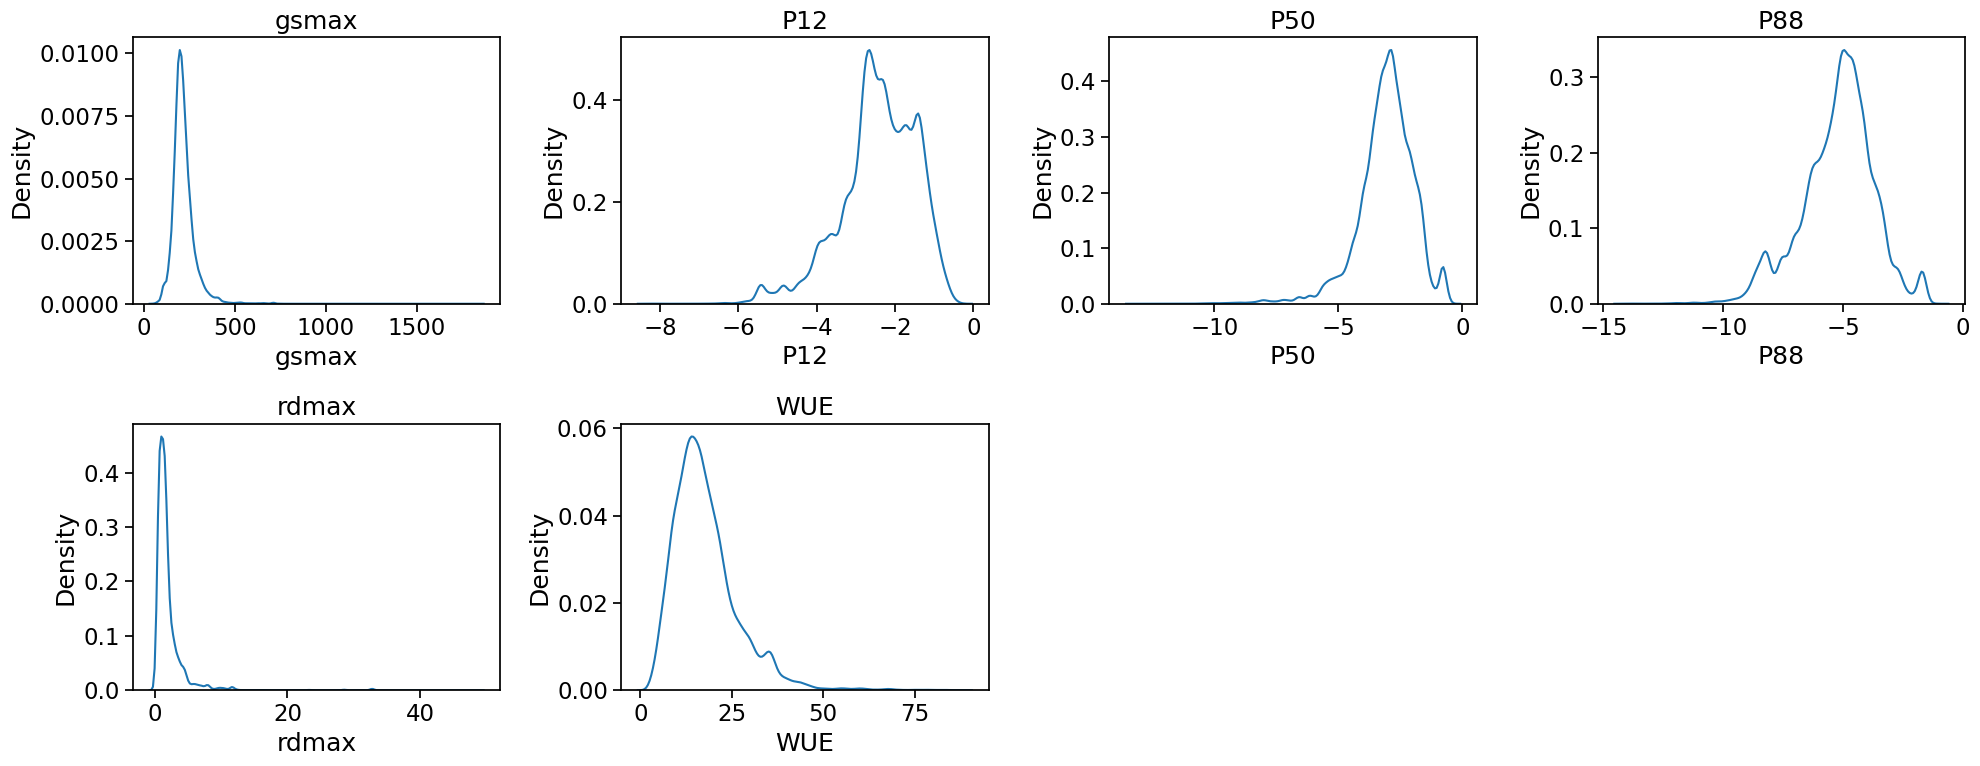

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_distributions(df, ncols=4):
    nrows = int(np.ceil(df.shape[1] / ncols))
    figsize = (ncols * 5, nrows * 4)
    _, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.kdeplot(df[col], ax=axes[i])
        axes[i].set_title(col)

    # clean up empty axes
    for i in range(len(df.columns), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# plot distributions for all cols starting with X
with sns.plotting_context("notebook", font_scale=1.5):
    plot_distributions(med_traits[["gsmax", "P12", "P50", "P88", "rdmax", "WUE"]])

## Link median traits with PFTs

### Load the PFTs

In [12]:
try_pfts_fp = Path("data/raw/try_pft_v2.parquet")
pfts = pd.read_parquet(try_pfts_fp)
pfts.head()

,AccSpeciesID,AccSpeciesName,pft
0,2,Abarema adenophora,Tree
1,3,Abarema barbouriana,Tree
2,5,Abarema curvicarpa,Tree
3,6,Abarema jupunba,Tree
4,7,Abarema laeta,Tree


Truncate species names to first two words and set species as index.

In [13]:
pfts = (
    pfts.drop(columns=["AccSpeciesID"])
    .assign(
        speciesname=lambda df: df.AccSpeciesName.str.extract(
            "([A-Za-z]+ [A-Za-z]+)", expand=False
        )
    )
    .assign(speciesname=lambda df: df.speciesname.str.lower())
    .dropna(subset="speciesname")
    .drop(columns=["AccSpeciesName"])
)

Link with traits

In [14]:
med_traits_pfts = med_traits.set_index("speciesname").join(pfts.set_index("speciesname"), how="inner")

In [15]:
med_traits_pfts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22216 entries, abarema ganymedea to zygogynum semecarpoides
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gsmax   22216 non-null  float32
 1   P12     22216 non-null  float32
 2   P50     22216 non-null  float32
 3   P88     22216 non-null  float32
 4   rdmax   22216 non-null  float32
 5   WUE     22216 non-null  float32
 6   pft     22216 non-null  object 
dtypes: float32(6), object(1)
memory usage: 867.8+ KB


In [16]:
print(
    "Pct species matched with PFT: "
    f"{med_traits_pfts.shape[0] / med_traits.shape[0]:.2%}"
)

Pct species matched with PFT: 39.97%


For now we'll have to make do with this low match percentage until we have an improved species <-> growth form list.